In [ ]:
# | default_exp importance_sampling
import jax

jax.config.update("jax_enable_x64", True)

# Importance Sampling for Partially Gaussian State Space Models
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.6)


After having observed $Y$ one is usually interested in properties of the conditional distribution of states $X$ given $Y$. Typically this means terms of the form

$$
\begin{align*}
\mathbf E (f(X) | Y) &= \mathbf E (f(X_0, \dots, X_n) | Y_0, \dots, Y_n) \\
    &= \int f(x_0, \dots, x_n) p(x_0, \dots, x_n | y_0, \dots, y_n) \mathrm d x_0 \dots \mathrm d x_n.
\end{align*}
$$

As the density $p(x|y)$ is known only up to a constant, we resort to importance sampling with a GLSSM, represented by its gaussian densities $g$. The [Laplace approximation](30_laplace_approximation.ipynb) and [(modified) efficient importance sampling](50_modified_efficient_importance_sampling.ipynb) perform this task for loc concave state space models where the states are jointly gaussian. 

Both methods construct surrogate [linear gaussian state space models](00_glssm.ipynb) that are parameterized by synthetic observations $z_t$ and their covariance matrices $\Omega_t$. Usually $\Omega_t$ is a diagonal matrix which is justified if the components of the observation vector at time $t$, $Y^i_t$, $i = 1, \dots, p$ are conditionally independent given states $X_t$.

These models are then based on the following SSM:
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &&\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &&t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) && t = 1, \dots, n \\
    S_t &= B_t X_t &&\\
    Z_t &= S_t + \eta_t && t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t) && t=0, \dots, n.
\end{align*}
$$

In this setting we can transform the expectation w.r.t the condtiional density $p(x|y)$ to one w.r.t the density $g(x|z)$.

$$
\begin{align*}
\int f(x) p(x|y) \mathrm d x &= \int f(x) \frac{p(x|y)}{g(x|z)} g(x|z) \mathrm d x\\
&= \int f(x) \frac{p(y|x)}{g(z|x)} \frac{g(z)}{p(y)} g(x|z) \mathrm d x.
\end{align*}
$$

Let $w(x) = \frac{p(y|x)}{g(z|x)} = \frac{p(y|s)}{g(z|s)}$ be the (unnormalized) importance sampling weights which only depend on $s_t = B_t x_t$, $t = 0, \dots, n$.

In [ ]:
# | export
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN,
)
import jax.numpy as jnp
from jaxtyping import Float, Array
from jax import vmap
from functools import partial
from isssm.typing import PGSSM


def log_weights_t(
    s_t: Float[Array, "p"],  # signal
    y_t: Float[Array, "p"],  # observation
    xi_t: Float[Array, "p"],  # parameters
    dist,  # observation distribution
    z_t: Float[Array, "p"],  # synthetic observation
    Omega_t: Float[Array, "p p"],  # synthetic observation covariance, assumed diagonal
) -> Float:  # single log weight
    """Log weight for a single time point."""
    p_ys = dist(s_t, xi_t).log_prob(y_t).sum()

    # omega_t = jnp.sqrt(jnp.diag(Omega_t))
    # g_zs = MVN_diag(s_t, omega_t).log_prob(z_t).sum()
    g_zs = MVN(s_t, Omega_t).log_prob(z_t).sum()

    return p_ys - g_zs


def log_weights(
    s: Float[Array, "n+1 p"],  # signals
    y: Float[Array, "n+1 p"],  # observations
    dist,  # observation distribution
    xi: Float[Array, "n+1 p"],  # observation parameters
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # synthetic observation covariances:
) -> Float:  # log weights
    """Log weights for all time points"""
    p_ys = dist(s, xi).log_prob(y).sum()

    # avoid triangular solve problems
    # omega = jnp.sqrt(vmap(jnp.diag)(Omega))
    # g_zs = MVN_diag(s, omega).log_prob(z).sum()
    g_zs = MVN(s, Omega).log_prob(z).sum()

    return p_ys - g_zs

Importance samples are generated from the smoothing distribution in the surrogate model, i.e. from  $g(x|z)$ using e.g. the [FFBS](10_kalman_filter_smoother.ipynb##FFBS) or [simulation smoother](./10_kalman_filter_smoother.ipynb#simulation-smoother) algorithm.


In [ ]:
from isssm.pgssm import simulate_pgssm, nb_pgssm_running_example
from isssm.laplace_approximation import laplace_approximation
import matplotlib.pyplot as plt

In [ ]:
# | export
from jaxtyping import Float, Array, PRNGKeyArray
from isssm.kalman import FFBS, simulation_smoother
import jax.random as jrn
from functools import partial
from isssm.typing import GLSSM, PGSSM


def pgssm_importance_sampling(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # covariance of synthetic observations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N"]
]:  # importance samples and weights
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

    key, subkey = jrn.split(key)
    s = simulation_smoother(glssm, z, N, subkey)

    model_log_weights = partial(log_weights, y=y, dist=dist, xi=xi, z=z, Omega=Omega)

    lw = vmap(model_log_weights)(s)

    return s, lw

Let us perform importance sampling for our [running example](20_lcssm.ipynb#running) using the model obtained by [the laplace approximation](30_laplace_approximation.ipynb). Notice that we obtain four times the number of samples that we specified, which comes from the use of [antithetics](./99_util.ipynb#antithetic-variables).

In [ ]:
key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
s_order = 4
model = nb_pgssm_running_example(
    n=100,
    s_order=s_order,
    Sigma0_seasonal=0.1 * jnp.eye(s_order - 1),
    x0_seasonal=jnp.zeros(s_order - 1),
)
N = 1
(x,), (y,) = simulate_pgssm(model, N, subkey)
proposal, info = laplace_approximation(y, model, 100)

[<matplotlib.lines.Line2D>]

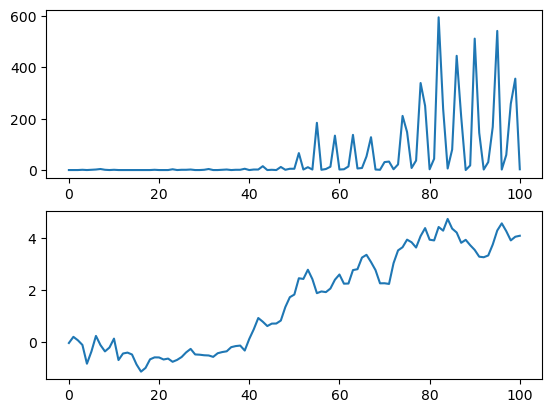

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(y)
axs[1].plot(x[:, 0])

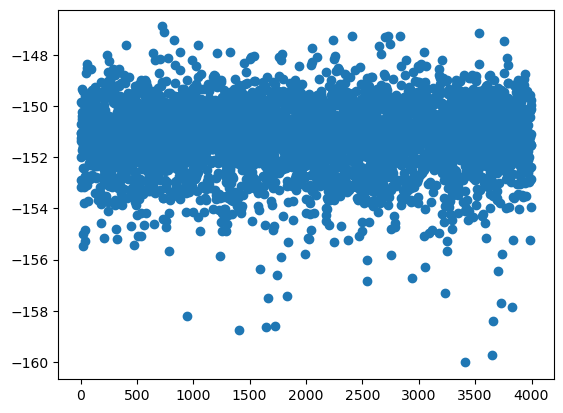

In [ ]:
N = 1000
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(y, model, proposal.z, proposal.Omega, N, subkey)
plt.scatter(jnp.arange(4 * N), lw)
plt.show()

Weights should be calculated on the log scale, but we need them on the usual scale to use for Monte-Carlo integration. These are called **auto-normalised weights** and defined by $W(X^i) = \frac{w(X^i)}{\sum_{i = 1}^N w(X^i)}$.

As weights are only known up to a constant, we make exponentiation numerically stable by substracting (on the log-scale) the largest weight, ensuring that $\log w^i \leq 0$ for all weights and so $\sum_{i = 1}^N w^i \leq N$. 

In [ ]:
# | export
from jaxtyping import Float, Array


def normalize_weights(
    log_weights: Float[Array, "N"]  # log importance sampling weights
) -> Float[Array, "N"]:  # normalized importance sampling weights
    """Normalize importance sampling weights."""
    max_weight = jnp.max(log_weights)

    log_weights_corrected = log_weights - max_weight

    weights = jnp.exp(log_weights_corrected)

    return weights / weights.sum()

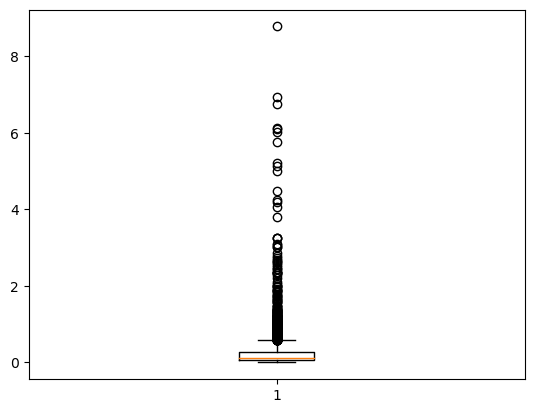

In [ ]:
weights = normalize_weights(lw)
plt.boxplot(weights[None] * N)
plt.show()

## Effective Sample Size

The effective sample size is an important diagnostic for the performance of importance sampling, it is defined by

$$
\text{ESS} = \frac{\left(\sum_{i = 1}^{N} w(X^i)\right)^2}{\sum_{i = 1}^N w^2(X_i)} = \frac{1}{\sum_{i = 1}^N W^2(X^i)}
$$

To compare different approximations one may also be interested in $\frac{\text{ESS}}{N} \cdot 100\%$, the percentage of effective samples.

In [ ]:
# | export
from jaxtyping import Float, Array


def ess(
    normalized_weights: Float[Array, "N"]  # normalized weights
) -> Float:  # the effective sample size
    """Compute the effective sample size of a set of normalized weights"""
    return 1 / (normalized_weights**2).sum()


def ess_lw(
    log_weights: Float[Array, "N"]  # the log weights
) -> Float:  # the effective sample size
    """Compute the effective sample size of a set of log weights"""
    return ess(normalize_weights(log_weights))


def ess_pct(
    log_weights: Float[Array, "N"]  # log weights
) -> Float:  # the effective sample size in percent, also called efficiency factor
    (N,) = log_weights.shape
    return ess_lw(log_weights) / N * 100

In [ ]:
ess(weights), ess_pct(lw)

(Array(889.98669, dtype=float64), Array(22.24966725, dtype=float64))

## Monte-Carlo Integration

In [ ]:
# | export
from jax import jit


@jit
def mc_integration(samples: Float[Array, "N ..."], log_weights: Float[Array, "N"]):
    return jnp.einsum("i...,i->...", samples, normalize_weights(log_weights))

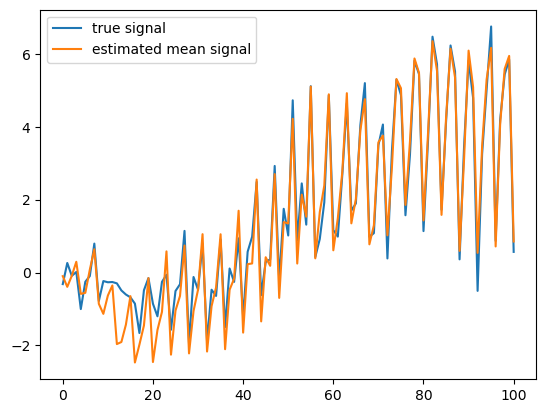

In [ ]:
sample_mean = mc_integration(samples, lw)
true_signal = (model.B @ x[..., None]).squeeze(axis=-1)
plt.plot(true_signal, label="true signal")
plt.plot(sample_mean, label="estimated mean signal")
plt.legend()
plt.show()

## Prediction
For prediction we are interested in the conditional expectations
$$
\mathbf E \left(Y_{n + t} | Y_0, \dots, Y_n\right),
$$
where we assume that the PGSSM has some known continuation after time $n$. 
We can estimate this conditional expectation by importance sampling. Given our samples $X^{i}_n$, $i = 1, \dots, N$, we simulate forward in time to obtain $X^i_{n + t}$. We may then estimate the conditional expectation by 
$$
\sum_{i = 1}^N W^i \mathbf E \left( Y_{n + t} | X_{n + 1} = X^i_{n + t}\right),
$$
by the dependency structure of the model ($Y_{n + t}$ is independent of $Y_0, \dots, Y_n$ given $X_{t + n}$.)

For prediction intervals, we follow the strategy provided by [@Durbin2012Time], Chapter 11.5.3: sort the univariate predictions, and the corresponding weights in the same order. Then the ECDF at $Y^i$, can be estimated as
$$
\sum_{j = 1}^i W^i.
$$
Linearly interpolating between these values gives an ECDF which we use to create prediction intervals.

In [ ]:
# | export
from isssm.typing import GLSSMProposal, GLSSMState
from isssm.kalman import kalman
from isssm.glssm import simulate_states
from isssm.util import mm_time_sim
from jax import jit
from scipy.optimize import minimize


def future_prediction_interval(dist, signal_samples, xi, log_weights, p):
    def integer_ecdf(y):
        return (
            dist(signal_samples, xi).cdf(y).squeeze(axis=-1)
            * normalize_weights(log_weights)
        ).sum()

    def ecdf(y):
        y_floor = jnp.floor(y)
        y_ceil = jnp.ceil(y)
        y_gauss = y - y_floor

        return integer_ecdf(y_floor) * (1 - y_gauss) + integer_ecdf(y_ceil) * y_gauss

    def pinball_loss(y, p):
        return (jnp.abs(ecdf(y) - p).sum()) ** 2

    mean = mc_integration(dist(signal_samples, xi).mean(), log_weights)
    result = minimize(pinball_loss, mean, args=(p,), method="Nelder-Mead")
    return result.x


def _prediction_percentiles(Y, weights, probs):
    Y_sorted = jnp.sort(Y)
    weights_sorted = weights[jnp.argsort(Y)]
    cumsum = jnp.cumsum(weights_sorted)

    # find indices of cumulative sum closest to probs
    # take corresponding Y_sorted values
    # with linear interpolation if necessary

    indices = jnp.searchsorted(cumsum, probs)
    indices = jnp.clip(indices, 1, len(Y_sorted) - 1)
    left_indices = indices - 1
    right_indices = indices
    left_cumsum = cumsum[left_indices]
    right_cumsum = cumsum[right_indices]
    left_Y = Y_sorted[left_indices]
    right_Y = Y_sorted[right_indices]
    # linear interpolation
    quantiles = left_Y + (probs - left_cumsum) / (right_cumsum - left_cumsum) * (
        right_Y - left_Y
    )
    return quantiles


prediction_percentiles = vmap(
    vmap(_prediction_percentiles, (1, None, None), 1), (2, None, None), 2
)


def predict(
    model: PGSSM,
    y: Float[Array, "n+1 p"],
    proposal: GLSSMProposal,
    future_model: PGSSM,
    N: int,
    key: PRNGKeyArray,
):

    key, subkey = jrn.split(key)
    signal_samples, log_weights = pgssm_importance_sampling(
        y, model, proposal.z, proposal.Omega, N, subkey
    )
    (N,) = log_weights.shape

    signal_model = GLSSM(
        proposal.u,
        proposal.A,
        proposal.D,
        proposal.Sigma0,
        proposal.Sigma,
        proposal.v,
        proposal.B,
        proposal.Omega,
    )

    @jit
    def future_sample(signal_sample, key):
        x_filt, Xi_filt, _, _ = kalman(signal_sample, signal_model)
        state = GLSSMState(
            future_model.u.at[0].set(x_filt[-1]),
            future_model.A,
            future_model.D,
            Xi_filt[-1],
            future_model.Sigma,
        )

        (x,) = simulate_states(state, 1, key)
        return x

    key, *subkeys = jrn.split(key, N + 1)
    subkeys = jnp.array(subkeys)

    future_x = vmap(future_sample)(signal_samples, subkeys)
    future_s = mm_time_sim(future_model.B, future_x)
    future_y = future_model.dist(future_s, future_model.xi).mean()

    return (future_x, future_s, future_y), log_weights

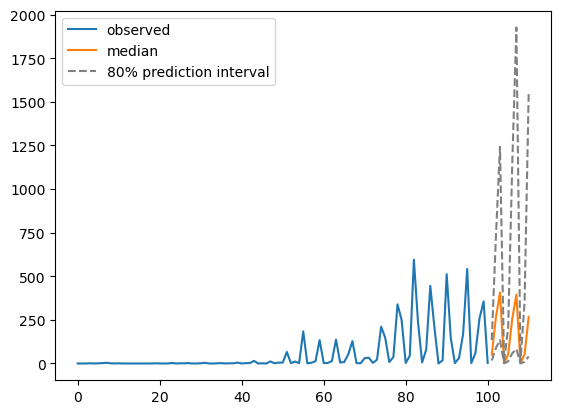

In [ ]:
key, subkey = jrn.split(key)
n_ahead = 10
ten_steps_ahead_model = PGSSM(
    model.u[: n_ahead + 1],
    model.A[:n_ahead],
    model.D[:n_ahead],
    model.Sigma0,
    model.Sigma[:n_ahead],
    model.v[: n_ahead + 1],
    model.B[: n_ahead + 1],
    model.dist,
    model.xi[: n_ahead + 1],
)
(_, s_pred, y_pred), log_weights_pred = predict(
    model, y, proposal, ten_steps_ahead_model, 1000, subkey
)

mean_y = (y_pred * normalize_weights(log_weights_pred)[:, None, None]).sum()
past_inds = jnp.arange(y.shape[0])
future_inds = jnp.arange(y.shape[0], y.shape[0] + n_ahead)
percentiles = prediction_percentiles(
    y_pred, normalize_weights(log_weights_pred), jnp.array([0.1, 0.5, 0.9])
)
lower, mid, upper = percentiles
plt.plot(past_inds, y, label="observed")
plt.plot(future_inds, mid[1:], label="median")
plt.plot(
    future_inds,
    lower[1:],
    linestyle="--",
    color="grey",
    label="80% prediction interval",
)
plt.plot(future_inds, upper[1:], linestyle="--", color="grey")
plt.legend()
plt.show()

In [ ]:
# | export
from isssm.kalman import to_signal_model


def prediction(
    f: callable,
    y,
    proposal: GLSSMProposal,
    model: PGSSM,
    N: int,
    key: PRNGKeyArray,
    probs: Float[Array, "k"],
    prediction_model=None,
):
    if prediction_model is None:
        prediction_model = model

    key, subkey = jrn.split(key)
    signal_samples, log_weights = pgssm_importance_sampling(
        y, model, proposal.z, proposal.Omega, N, subkey
    )
    N = signal_samples.shape[0]

    signal_model = to_signal_model(proposal)

    def state_sample(signal_sample, key):
        (x_sample,) = FFBS(signal_sample, signal_model, 1, key)
        return x_sample

    key, *subkeys = jrn.split(key, N + 1)
    subkeys = jnp.array(subkeys)
    x_samples = vmap(state_sample)(signal_samples, subkeys)
    s_samples = mm_time_sim(prediction_model.B, x_samples)

    key, subkey = jrn.split(key)
    y_prime_samples = prediction_model.dist(
        s_samples, prediction_model.xi[None]
    ).sample(seed=subkey)

    f_samples = vmap(f)(x_samples, signal_samples, y_prime_samples)

    mean_f = mc_integration(f_samples, log_weights)
    sd_f = jnp.sqrt(mc_integration(f_samples**2, log_weights) - mean_f**2)

    if f_samples.ndim == 3:
        percentiles = prediction_percentiles(
            f_samples, normalize_weights(log_weights), probs
        )
    elif f_samples.ndim == 2:
        percentiles = vmap(_prediction_percentiles, (1, None, None), 1)(
            f_samples, normalize_weights(log_weights), probs
        )
    elif f_samples.ndim == 1:
        percentiles = _prediction_percentiles(
            f_samples, normalize_weights(log_weights), probs
        )

    return mean_f, sd_f, percentiles

NameError: name 'GLSSMProposal' is not defined

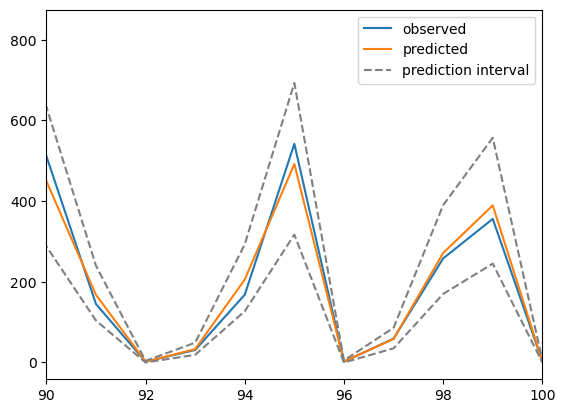

In [ ]:
def f(x, s, y_prime):
    return y_prime[:, 0:1]


key, subkey = jrn.split(key)
mean, sd, quants = prediction(
    f, y, proposal, model, 10000, subkey, jnp.array([0.1, 0.5, 0.9])
)

plt.plot(y, label="observed")
plt.plot(mean, label="predicted")
plt.plot(quants[0], linestyle="--", color="grey", label="prediction interval")
plt.plot(quants[2], linestyle="--", color="grey")
plt.xlim(90, 100)
plt.legend()
plt.show()

In [ ]:
quants[2, 99], y[99]

(Array([557.], dtype=float64), Array([356.], dtype=float64))

In [ ]:
from tensorflow_probability.substrates.jax.distributions import NegativeBinomial

NegativeBinomial(20, jnp.log(356) - jnp.log(20)).cdf(557)

Array(0.98567769, dtype=float64)

In [ ]:
future_prediction_interval(
    model.dist, s_pred[:, 0], model.xi[0], log_weights_pred, 0.5
), mid[0]

(array([49.47880729]), Array([52.31199429], dtype=float64))

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()